# Construindo um Classificador de Textos
Uma das aplicações mais comuns em mineração de textos é a classificações de documentos em categorias pré-definidas, sejam elas autorais, temáticas, temporais ou outras. 

Neste capítulo iremos explorar os passos necessários para o desenvolvimento de um classificador de documentos utilizando as análises feitas sobre o corpus do DHBB nos capítulos anteriores.

Para esta tarefa utilizaremos modelos de machine learning clássicos disponibilizados na biblioteca [Scikit-Learn](https://scikit-learn.org/). Começaremos então importando algumas funcionalidades a partir do Scikit-Learn. Os demais imports já foram utilizados anteriormente.

In [19]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec, word2vec
import spacy
from spacy import displacy
from string import punctuation
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

## Preparando o corpus
Vamos utilizar o corpus do DHBB conforme armazenado na biblioteca SQLite anteriormente. Abaixo iremos desenvolver um iterador sobre o corpus que fará um preprocessamento básico dos documentos.

In [2]:
eng = create_engine("sqlite:///minha_tabela.sqlite")
nlp = spacy.load("pt_core_news_sm")
class DHBBCorpus:
    def __init__(self, ndocs=10000):
        self.ndocs = min(7687,ndocs)
        self.counter = 1
    def __iter__(self):
        with eng.connect() as con:
            res = con.execute(f'select corpo from resultados limit {self.ndocs};')
            for doc in res:
                d = self.pre_process(doc[0])
                if self.counter%10 == 0:
                    print (f"Verbete {self.counter} de {self.ndocs}\r", end='')
                
                yield d
                self.counter += 1
    def pre_process(self, doc):
        n = nlp(doc, disable=['tagger', 'ner','entity-linker', 'textcat','entity-ruler','merge-noun-chunks','merge-entities','merge-subtokens'])
        results = [token.text.strip().strip(punctuation) for token in n if not token.is_stop]
        return results

## Carregando o Modelo Word2vec
Vamos utilizar a representação vetorial do corpus construida anteriormente como base para o treinamento do classificador. 

In [3]:
model = Word2Vec.load('dhbb.w2v')

In [4]:
model.wv.vectors.shape

(38762, 100)

Como  o word2vec é uma representação vetorial do vocabulário do corpus, e desejamos treinar um modelo para classificar documentos, precisamos primeiro construir uma representação dos documentos do corpus no mesmo espaço vetorial gerado pelo Word2vec.

Na função abaixo, contruimos um vetor de documento que é a média dos vetores das palavras únicas que este contém.

In [5]:
def build_document_vector(text):
    """
    Build a scaled vector for the document (mean of the words present in it)
    :param text: document to be vectorized (tokenized)
    :param model: word2vec model
    :return:
    """
    feature_count = model.wv.vectors.shape[1]
    vec = np.zeros(feature_count).reshape((1, feature_count))
    count = 0.
    

    for word in text:
        try:
            vec += model.wv[word].reshape((1, feature_count))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

In [6]:

def gera_docv(n):
    corpus = DHBBCorpus(n)
    for doc in corpus:
        v = build_document_vector(set(doc))
        yield v


## Preparando os dados treinamento do Classificador

In [7]:
gerador = gera_docv(10000)
data = pd.DataFrame(data=np.vstack([a for a in gerador]), columns=range(100))
data

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.299355,-0.374758,-0.221921,-0.014266,-0.362556,0.058059,0.646023,-0.032011,-0.375196,0.106362,...,-0.078524,-0.164474,-0.235533,0.010279,0.767313,0.173925,0.212851,-0.657804,-0.501652,0.051704
1,-0.047586,-0.047138,-0.192919,0.581458,0.155535,0.226447,0.213957,-0.109043,-0.071011,0.108084,...,0.344092,0.060079,-0.120950,0.116963,0.260116,0.291860,0.169258,-0.301641,-0.520335,0.310200
2,0.193163,-0.186792,-0.268551,0.111721,-0.208734,0.006146,0.070133,-0.324108,-0.118932,-0.003408,...,-0.189952,0.421482,-0.118719,0.006936,0.213612,0.025497,-0.034283,-0.273559,0.126102,0.067360
3,0.006157,-0.060400,-0.279931,0.379012,0.006151,0.142672,0.170820,-0.025366,-0.218879,0.170935,...,0.195555,0.127540,0.024253,0.031326,-0.001970,0.220645,0.003517,-0.162352,-0.289485,0.344416
4,0.030312,-0.264496,-0.444708,0.091338,-0.521767,-0.225814,0.259753,0.601325,-0.751790,0.503691,...,0.047659,-0.016358,-0.346371,-0.465766,1.352994,0.284854,0.753584,-0.441544,-0.971092,0.049266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7682,-0.097823,-0.078891,-0.378231,0.586076,-0.060112,0.270353,0.322826,-0.225374,-0.039686,-0.033435,...,0.272789,0.018996,-0.305199,0.141629,0.163269,0.199732,0.046464,-0.307171,-0.611295,0.099506
7683,0.179406,-0.121504,-0.562740,0.047880,-0.832265,-0.569388,0.306019,0.671887,-0.339240,0.517512,...,-0.486355,-0.092336,-0.464590,-0.744464,1.226775,0.115940,0.150833,-0.272562,-0.524888,-0.228353
7684,-0.305582,-0.415389,-0.494118,0.070715,-0.200167,0.158698,0.495111,0.040753,-0.143941,0.047398,...,-0.010479,-0.002587,-0.336644,-0.023329,0.161481,0.408541,0.005779,-0.390632,-0.423871,0.200473
7685,0.115212,-0.191013,-0.055094,-0.002285,-0.269068,0.113420,0.496748,-0.107383,-0.168153,0.263151,...,-0.035157,-0.105682,-0.496205,-0.084804,0.417006,0.080934,0.181313,-0.414772,-0.182550,0.041914


### Definindo a categoria de cada documento para o treinamento

In [26]:
def gera_alvo():
    df = pd.read_sql_query('select natureza from resultados', con=eng)
    alvo = df.natureza.values=='biográfico'
    return alvo
Y = gera_alvo()
len(Y)-sum(Y)

963

In [30]:
biog = data.iloc[Y]
tem = data.iloc[~Y]

In [37]:
import random
random.shuffle(list(range(1926)))

In [53]:
data2 = pd.concat([biog[:963],tem],axis=0)
Y2 = np.array([True]*963 + [False]*963)
data2['Y2'] = Y2
data2 = data2.sample(frac=1).reset_index(drop=True)
Y2 = data2.pop('Y2')
data2

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.287586,0.392659,-0.731287,0.627016,-0.042116,-0.104181,0.339614,0.169082,-0.124376,0.007306,...,0.151552,-0.554600,-0.420021,-0.156081,0.437308,0.750317,0.121929,-0.366128,-0.991161,0.489637
1,0.109333,-0.300749,0.025365,0.283070,-0.123726,0.308500,-0.000194,-0.048570,0.032761,0.176519,...,0.133429,0.438715,-0.051695,0.056249,-0.376985,-0.123494,-0.177922,-0.156822,0.122555,-0.048608
2,-0.297096,-0.127949,-0.654515,0.292929,0.067958,0.016514,0.430008,0.222950,-0.428702,0.359814,...,0.199933,-0.778702,-0.294653,-0.259145,0.076912,0.379931,0.184168,-0.444600,-0.881913,0.457874
3,-0.181810,-0.061366,-0.338914,0.376706,-0.041893,0.136617,0.498730,-0.181095,-0.240299,0.184389,...,0.183034,-0.156569,-0.249727,-0.045820,0.042241,0.217679,0.112461,-0.107007,-0.475181,0.196008
4,-0.167694,-0.014426,-0.351949,0.304469,0.211838,0.401343,0.309968,0.245993,-0.207923,0.281746,...,0.259211,-0.137243,0.003007,-0.034965,0.620501,0.619169,0.337761,-0.242318,-0.579613,0.505532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921,0.344708,-0.181017,-0.147162,0.043743,-0.210840,-0.029625,0.021876,-0.294783,-0.089625,-0.034736,...,-0.186432,0.505796,-0.050912,0.095325,0.103774,0.005002,-0.107959,-0.238199,0.180362,0.081891
1922,0.287809,-0.193073,-0.335034,-0.007505,-0.293801,0.012606,0.366060,-0.364010,-0.234743,-0.010948,...,-0.401236,0.316644,-0.056814,-0.025062,0.426827,0.071936,-0.110882,-0.337798,-0.082237,0.173368
1923,-0.026300,-0.045847,-0.166971,0.395506,0.043388,0.076857,0.268256,0.095490,-0.105613,0.204073,...,0.223723,-0.001837,-0.111942,0.014763,0.130912,0.213542,-0.071582,-0.117143,-0.304340,0.364136
1924,-0.217996,0.257454,-0.374343,0.571969,0.037497,0.110626,0.107253,0.224317,-0.407639,0.038237,...,0.241646,-0.559145,-0.312735,-0.056651,0.704004,0.435032,0.380705,-0.434107,-1.058273,0.222910


In [39]:
from matplotlib import pyplot as plt
%matplotlib inline
def print_class_report(Xtest, Ytest, clf, clf_name):
    """
    Prints Classification report
    :param Xtest:
    :param Ytest:
    :param clf: trained classifier
    :param clf_name: Name for the classifier
    """
    y_predict = clf.predict(Xtest)
    print('\nClassification Report for {}:\n'.format(clf_name))
    print(classification_report(Ytest, y_predict, target_names=['Temático', 'Biográfico']))
    

def plot_roc(probas):
    tprs = []
    fprs = []


    labels = ['False positive rate', 'True Positive rate']
    for k, v in probas.items():
        roc_aucs = []
        for j, fold in enumerate(v):
            try:
                fpr, tpr, thresholds = roc_curve(fold[1], fold[0][:, 1])
            except IndexError:
                print(fold[0], fold[0].shape)
                continue
            roc_aucs.append(auc(fpr, tpr))
            tprs.append([float(t) for t in tpr])
            fprs.append([float(f) for f in fpr])

        print('{}: AUCs: {}'.format(k, str(roc_aucs)))
    plt.scatter(fprs, tprs, [], "ROC curve", "points", 0, 0)
    

## Definindo os modelos

In [55]:
rfclf = RandomForestClassifier(n_estimators=400, criterion='entropy', n_jobs=-1, min_samples_leaf=3, warm_start=True, verbose=0)
etclf = ExtraTreesClassifier(n_estimators=400, n_jobs=-1,min_samples_leaf=3, warm_start=True, verbose=0)

In [56]:
vcclf = VotingClassifier(estimators=[('rf', rfclf), ('et', etclf)], voting='soft', weights=[1,1])

## Treinando e validando o classificador

==> Fitting:
==> Extra Trees
Random Forest
Voting
==> Scoring:
==> Fitting:
==> Extra Trees
Random Forest
Voting


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:368: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:368: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


==> Scoring:
==> Fitting:
==> Extra Trees
Random Forest
Voting


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:368: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:368: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


==> Scoring:

Classification Report for ET:

              precision    recall  f1-score   support

    Temático       0.00      0.00      0.00       249
  Biográfico       0.48      1.00      0.65       233

    accuracy                           0.48       482
   macro avg       0.24      0.50      0.33       482
weighted avg       0.23      0.48      0.32       482


Classification Report for RF:

              precision    recall  f1-score   support

    Temático       0.00      0.00      0.00       249
  Biográfico       0.48      1.00      0.65       233

    accuracy                           0.48       482
   macro avg       0.24      0.50      0.33       482
weighted avg       0.23      0.48      0.32       482



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report for Voting:

              precision    recall  f1-score   support

    Temático       0.00      0.00      0.00       249
  Biográfico       0.48      1.00      0.65       233

    accuracy                           0.48       482
   macro avg       0.24      0.50      0.33       482
weighted avg       0.23      0.48      0.32       482

RF: AUCs: [0.999822695035461, 1.0, 1.0]
[0.00567857 0.99432143] (2,)
[9.375000e-04 9.990625e-01] (2,)
[0.06672768 0.93327232] (2,)
Voting: AUCs: []


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: s must be a scalar, or the same size as x and y

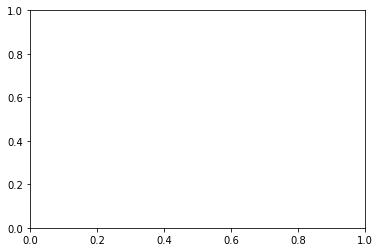

In [57]:
from collections import defaultdict
scaler = StandardScaler()

acc_hist = defaultdict(lambda: [])

Xtrain,Xtest,Ytrain,Ytest = train_test_split(data2.values,Y2, test_size=.25)

probas = defaultdict(lambda: [])
skf = StratifiedKFold(3, shuffle=True)

for train_index, test_index in skf.split(Xtrain, Ytrain):
    scaler.fit(X)
    X = scaler.transform(X)
    print("==> Fitting:")
    print("==> Extra Trees")
    etclf.fit(X[train_index],Y[train_index])
    print("Random Forest")
    rfclf.fit(X[train_index], Y[train_index])
    probas['RF'].append((rfclf.predict_proba(X[test_index]), Y[test_index]))
    print("Voting")
    vcclf.fit(X[train_index], Y[train_index])
    probas['Voting'].append(vcclf.predict_proba(X[test_index]))
    print("==> Scoring:")
    acc_hist['ET'].append(cross_val_score(etclf, X[test_index], Y[test_index], cv=2, n_jobs=-1).mean())

    acc_hist['RF'].append(cross_val_score(rfclf, X[test_index], Y[test_index], cv=2, n_jobs=-1).mean())
    acc_hist['Voting'].append(vcclf.score(X[test_index], Y[test_index]))
print_class_report(Xtest, Ytest, etclf, 'ET')
print_class_report(Xtest, Ytest, rfclf, 'RF')
print_class_report(Xtest, Ytest, vcclf, 'Voting')

#     plot_learning(acc_hist)
plot_roc(probas)

# print('trained {} documents.'.format((n+1)*batchsize))
df_acc = pd.DataFrame(acc_hist)

In [46]:
Xtrain.shape

(5765, 100)

In [47]:
Ytrain.shape

(5765,)